# <a href="https://thetahat.ru/courses/ad" target="_top">Введение в анализ данных</a>

## Кластеризация

Как мы выяснили на <a href="https://thetahat.ru/files/ad/main/7/lec7.pdf" target="_top">лекции</a>, задача кластеризации имеет множество разных особенностей, например, интерпретация, неоднозначность, оценка качества. В данном ноутбуке мы рассмотрим несколько примеров кластеризации методами из библиотеки <a target="_top" href="https://scikit-learn.org/">Scikit-Learn</a>. В качестве данных рассмотрим как искусственные данные, так и реальные &mdash; ответы на вопросы в боте. Будем также пользоваться понижением размерности, о которых можно почитать в <a href="https://thetahat.ru/courses/ad/main/7/pca" target="_top">предыдущем ноутбуке</a>, а так же методами обработки естественного языка, о которых можно почитать в прошлой <a href="https://thetahat.ru/files/ad/main/6/lec6.pdf" target="_top">лекции</a> и <a href="https://thetahat.ru/courses/ad/main/6/nlp_sem_part1" target="_top">семинаре</a>.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.auto import tqdm
from typing import Union, List, Optional

import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.offline as pyo
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
import sklearn.datasets
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel, PreTrainedModel, PreTrainedTokenizer
from sentence_transformers import SentenceTransformer

sns.set(style="darkgrid", palette="Set2")
pio.renderers.default = "notebook"
pyo.init_notebook_mode(connected=True)
pd.options.display.max_colwidth = 100
RANDOM_STATE = 42

В данном ноутбуке сравним различные способы кластеризации данных:
- <a target="_top" href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">KMeans</a>
- <a target="_top" href="https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html">EM-алгоритм</a>
- <a target="_top" href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN</a>

Вначале все методы будем применять на искусственном датасете из 4 кластеров. Поэтому начнем с генерации этого датасета:

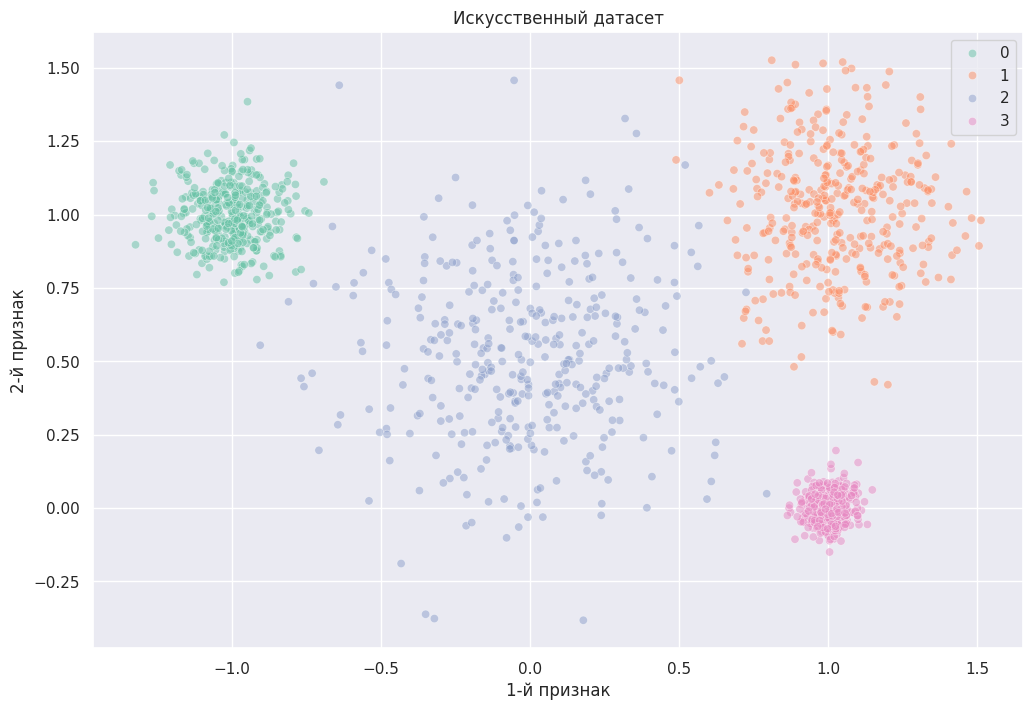

In [2]:
n_samples = 1500

# Генерация данных
data, clusters = sklearn.datasets.make_blobs(
    n_samples=n_samples,
    centers=[[-1, 1], [1, 1], [0, 0.5], [1, 0]],
    cluster_std=[0.1, 0.2, 0.3, 0.05],
    random_state=RANDOM_STATE,
)

# Визуализация
plt.figure(figsize=(12, 8))
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=clusters, alpha=0.5, palette="Set2")
plt.title("Искусственный датасет")
plt.xlabel("1-й признак")
plt.ylabel("2-й признак")
plt.show()

### 1. <a target="_top" href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html">KMeans</a>

K-Means – это метод машинного обучения без учителя (unsupervised learning), который позволяет группировать данные в заранее заданное число кластеров.

Вспомним вкратце схему работы:
1. **Инициализация.** Сначала метод случайным образом выбирает центры для требуемого числа кластеров.
2. **Выбор кластера.** Каждый элемент датасета присваивается к ближайшему центру кластера, основываясь на заданной метрике расстояния (обычно это Евклидово расстояние).
3. **Пересчет центров.** Вычисляются новые центры для кластеров, которые представляют собой центры масс всех точек, принадлежащих к данному кластеру.
4. Шаги 2 и 3 повторяются до тех пор, пока изменения в кластерах не прекратятся или не будет достигнуто максимальное количество итераций.

В результате мы получаем кластеризацию данных, в которой элементы в пределах одного кластера схожи между собой, а разные кластеры отличимы друг от друга.


#### Реализация KMeans из sklearn

> `KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='auto')`  
>
> *Самый важный параметр*  
> * `n_clusters` &mdash; число кластеров.
>
> *Наиболее важные остальные параметры*   
> * `init` &mdash; метод для начального определения центров кластеров. По дефолту используется `k-means++`. Подробнее про этот метод можно найти <a target="_top" href="https://ru.wikipedia.org/wiki/K-means%2B%2B">здесь</a>.   
> * `n_init` &mdash; количество запусков KMeans из различных начальных приближений.
> * `max_iter` &mdash; максимальное количество итераций.  
> * `tol`  &mdash; максимальное  относительное отличие в метрике, при котором можно сказать, что метод сошелся.
> * `verbose` &mdash; позволяет отображать работу метода на промежуточных шагах с определенной периодичностью. Может пригодится работы с очень большими данными.  
> * `random_state` &mdash; позволяет зафиксировать случайность.  
> * `n_jobs` &mdash; позволяет распараллелить вычисления на `n_jobs` задач. Может пригодится работы с очень большими данными.  
>
> *Методы*
> * `fit(self, X[, y, sample_weight])` &mdash; обучиться на данных `X`.
> * `predict(self, X[, sample_weight])` &mdash; вернуть номера кластеров для каждого элемента `X`.
> * `fit_predict(self, X[, y, sample_weight])` &mdash; обучиться на данных `X` и вернуть номера кластеров.
>
> *Наиболее важные атрибуты*  
> * `cluster_centers_` &mdash; центры кластеров.  
> * `labels_` &mdash; метки для данных.
> * `inertia_` &mdash; расстояния от точек до центров кластеров.

---

Пошагово посмотрим как сходится k-means. Для этого будем использовать собственноручно написанный k-means, так как из реализации в sklearn тяжело вытаскивать промежуточные шаги

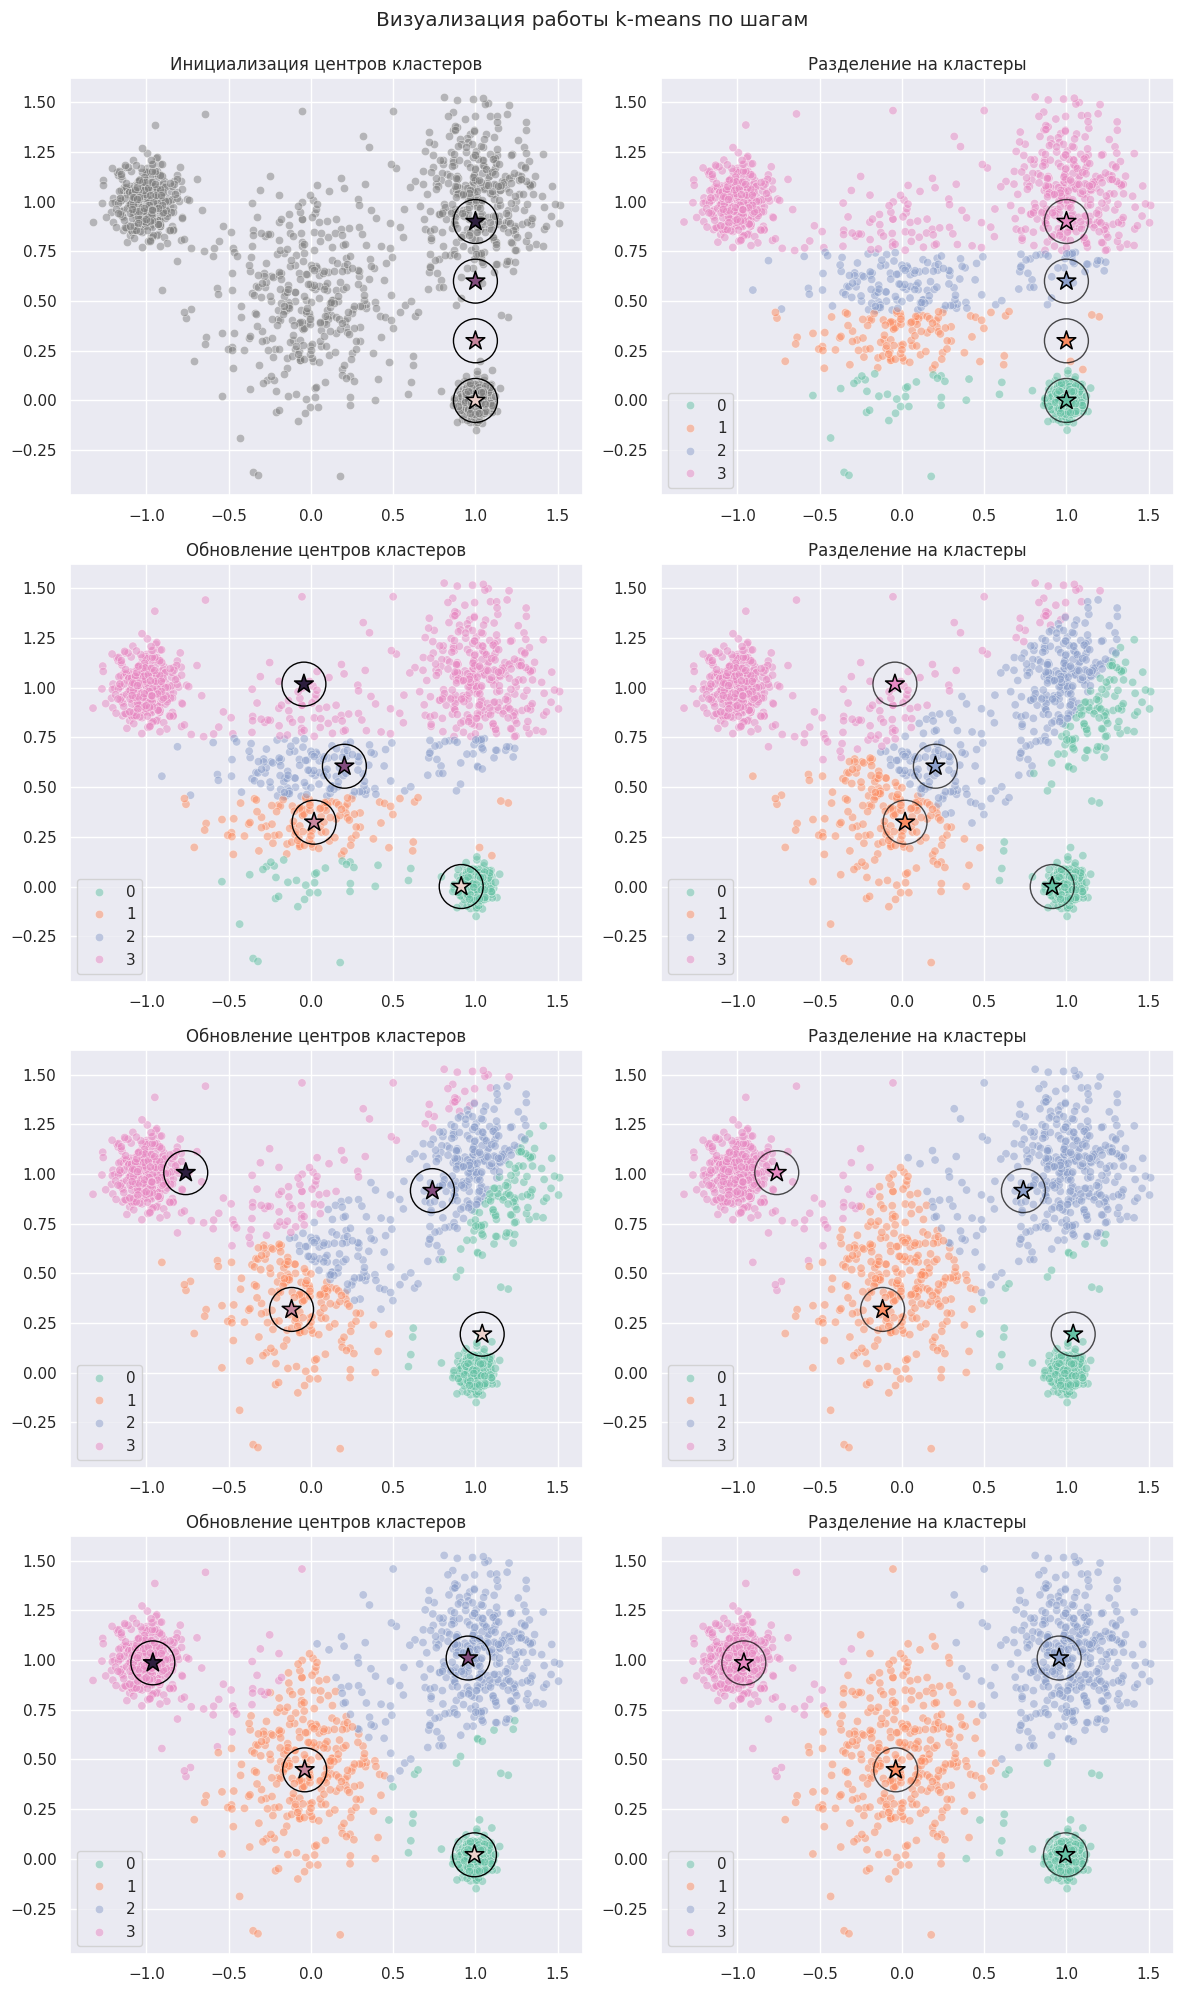

In [3]:
plt.figure(figsize=(12, 20))
plt.suptitle("Визуализация работы k-means по шагам", y=0.995)

# Начальные значения
centres = np.array([[1, 0.0], [1, 0.3], [1, 0.6], [1, 0.9]])
n_clusters = len(centres)
y_pred = None

for iter_idx in range(1, n_clusters + 1):
    plt.subplot(4, 2, iter_idx * 2 - 1)

    if iter_idx == 1:
        plt.title("Инициализация центров кластеров")
        sns.scatterplot(x=data[:, 0], y=data[:, 1], c="gray", alpha=0.5)
    else:
        plt.title("Обновление центров кластеров")
        sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=y_pred, alpha=0.5, palette="Set2")
    sns.scatterplot(
        x=centres[:, 0],
        y=centres[:, 1],
        hue=np.arange(n_clusters),
        marker="*",
        s=200,
        edgecolors="black",
        legend=False,
    )
    sns.scatterplot(
        x=centres[:, 0],
        y=centres[:, 1],
        s=1000,
        edgecolors="black",
        facecolor="none",
        linewidths=1,
    )

    # Предсказание
    y_pred = np.argmin(
        [np.sum((data - centres[j]) ** 2, axis=1) for j in range(n_clusters)], axis=0
    )

    plt.subplot(4, 2, iter_idx * 2)

    plt.title("Разделение на кластеры")
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=y_pred, alpha=0.5, palette="Set2")
    sns.scatterplot(
        x=centres[:, 0],
        y=centres[:, 1],
        hue=np.arange(n_clusters),
        marker="*",
        s=200,
        edgecolors="black",
        legend=False,
        palette="Set2",
    )
    sns.scatterplot(
        x=centres[:, 0],
        y=centres[:, 1],
        alpha=0.7,
        s=1000,
        edgecolors="black",
        facecolor="none",
        linewidths=1,
    )

    # Переопределение центров кластеров
    centres = np.array(list(np.mean(data[y_pred == j], axis=0) for j in range(n_clusters)))

plt.tight_layout()
plt.show()

Больше примеров визуализации работы k-means можно найти <a target="_top" href="https://www.naftaliharris.com/blog/visualizing-k-means-clustering/">здесь</a>.

Попробуем применить k-means для разного числа кластеров.

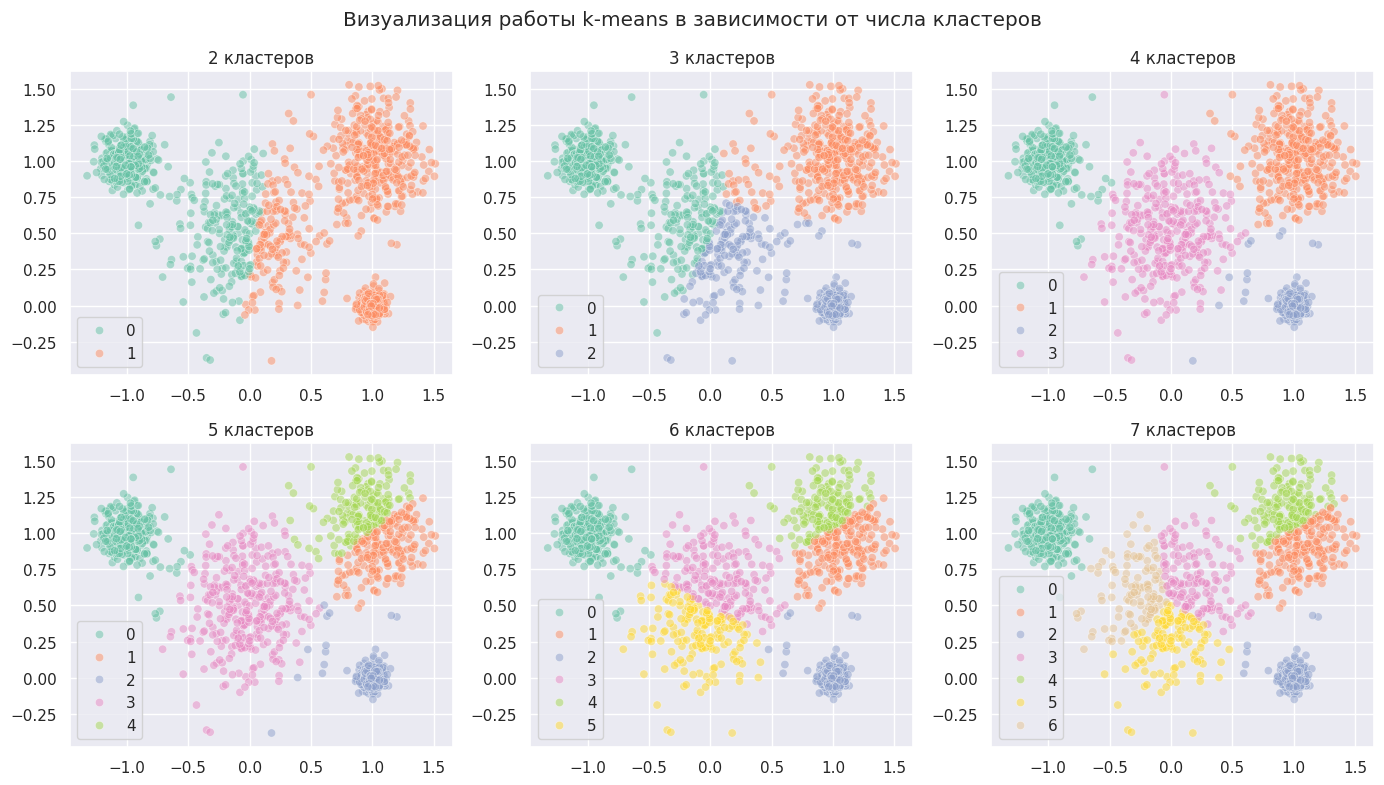

In [4]:
fig = plt.figure(figsize=(14, 8))
fig.suptitle("Визуализация работы k-means в зависимости от числа кластеров")

for n_clusters in range(2, 8):
    # Предсказание
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=RANDOM_STATE)
    kmeans.fit(data)
    y_pred = kmeans.predict(data)

    # Визуализация
    plt.subplot(2, 3, n_clusters - 1)
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=y_pred, alpha=0.5, palette="Set2")
    plt.title(f"{n_clusters} кластеров")

plt.tight_layout()
plt.show()

Видно, что у KMeans есть проблемы, если кластеры имеют разный разброс. Например, в данном случае к самому компактному синему кластеру также отнеслись точки от двух соседних кластеров.

### 2. <a target="_top" href="https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html">EM-алгоритм</a>

EM-алгоритм (Expectation-Maximization) &mdash; в общем случае мощный подход для нахождения оценок в моделях с ненаблюдаемыми латентными величинами. В случае кластеризации, рассматривается частный случай метода, предполагая, что распределения данных является смесью нормальных (гауссовых) распределений, то есть плотность равна взвешенной плотности нескольких нормальных величин. Именно поэтому в sklearn этот метод назван `GaussianMixture`.

Вспомним основные шаги:
1. **Инициализация.** Выбираются начальные значения параметров кластеров (например, с использованием k-means).
2. **E-шаг (Expectation).** На основе текущих параметров распределений оцениваются вероятности принадлежности объектов выборки к кластерам.
3. **M-шаг (Maximization).** Используя вероятности, полученные на предыдущем шаге, оцениваются параметры модели (средние и ковариации нормальных распределений).
4. Шаги E и M повторяются пока метод не сойдется.


#### Реализация EM-алгоритма из sklearn

> `GaussianMixture(n_components=1, covariance_type='full', n_init=1, max_iter=100, tol=0.001, init_params='kmeans', random_state=None, verbose=0)`  
>
> *Самый важный параметр*  
> * `n_components` &mdash; число кластеров.
>
> *Наиболее важные остальные параметры*   
> * `covariance_type` &mdash; тип матрицы ковариаций, дефолтное значение `full` означает, что для каждого кластера будет своя произвольная матрица;
> * `init_params` &mdash; метод для начального определения центров кластеров. По дефолту используется `k-means`, то есть кластеры инициализируются с помощью обычного k-means;
> * `n_init` &mdash; количество запусков EM-алгоритма из различных начальных приближений;
> * `max_iter` &mdash; максимальное количество итераций;
> * `tol`  &mdash; максимальное  относительное отличие в метрике, при котором можно сказать, что метод сошелся;
> * `verbose` &mdash; позволяет отображать работу метода на промежуточных шагах с определенной периодичностью. Может пригодится работы с очень большими данными.  
> * `random_state` &mdash; позволяет зафиксировать случайность.
>
> *Методы*  
> * `fit(self, X[, y, sample_weight])` &mdash; обучиться на данных `X`;
> * `predict(self, X[, sample_weight])` &mdash; вернуть номера кластеров для каждого элемента `X`;
> * `fit_predict(self, X[, y, sample_weight])` &mdash; обучиться на данных `X` и вернуть номера кластеров.
>
> *Наиболее важные атрибуты*  
> * `means_` &mdash; центры кластеров;
> * `covariances_` &mdash; разброс кластеров (оценка матриц ковариаций).


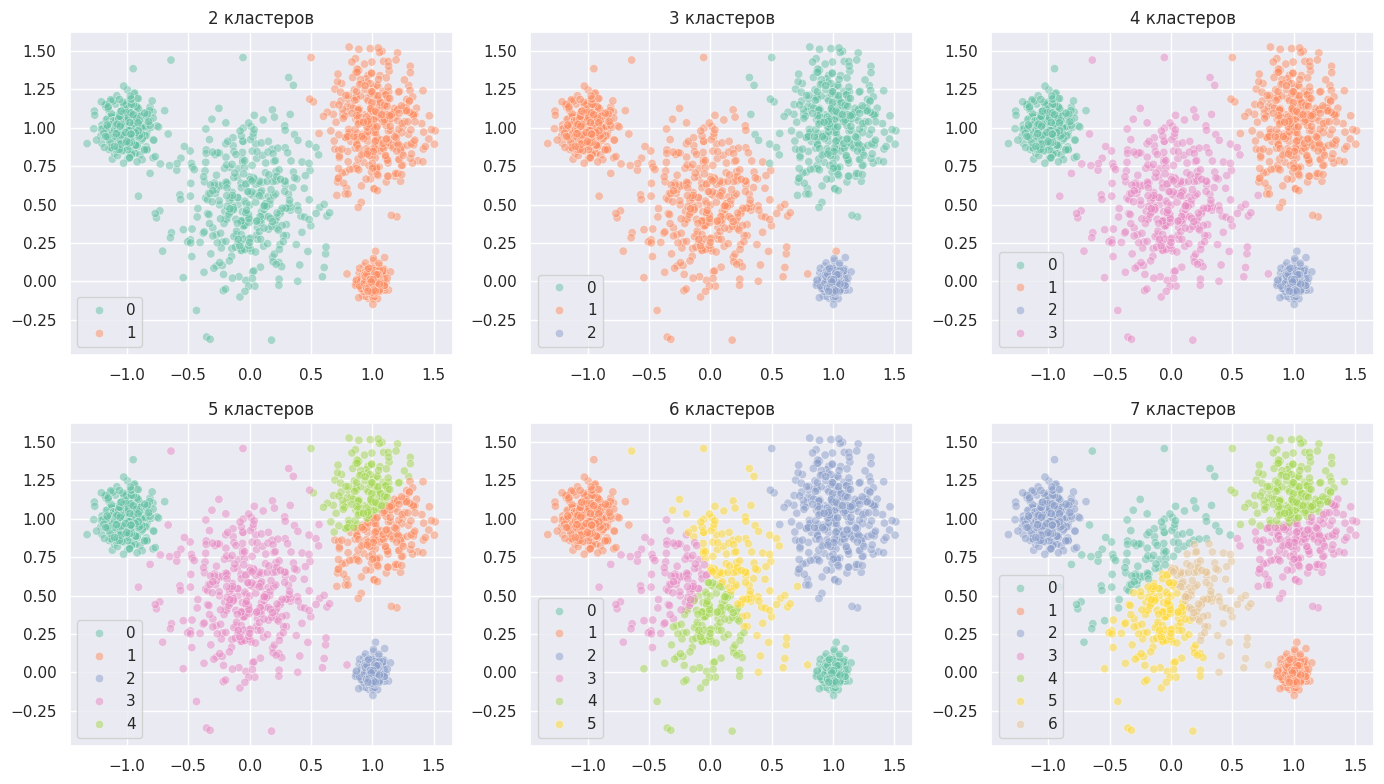

In [5]:
plt.figure(figsize=(14, 8))
fig.suptitle("Визуализация работы EM-алгоритма в зависимости от чила кластеров")

for n_clusters in range(2, 8):
    # Предсказание
    em_algo = GaussianMixture(n_components=n_clusters, n_init=10, random_state=RANDOM_STATE)
    em_algo.fit(data)
    y_pred = em_algo.predict(data)

    # Визуализация
    plt.subplot(2, 3, n_clusters - 1)
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=y_pred, alpha=0.5, palette="Set2")
    plt.title(f"{n_clusters} кластеров")

plt.tight_layout()
plt.show()

Видим, что для четырех кластеров получилось почти идеальное разделение. Поскольку теперь модель выучивает свою дисперсию для каждого кластера, решилась проблема с разным разбросом в разных кластерах, возникающая в k-means.

### 3. <a target="_top" href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN</a>

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) &mdash; еще один метод кластеризации, основанный на плотности точек. Он позволяет выявить кластеры произвольной формы и обнаружить выбросы (шум в данных). В отличие от K-Means и EM-алгоритма, DBSCAN не требует заранее заданного числа кластеров и устойчив к выбросам, однако часто требует нетривиальный подбор двух основных параметров `eps` и `min_samples`.

Вспомним схему работы DBSCAN:
1. **Определение соседей.** Для каждой точки метод ищет соседние точки, расстояние до которых меньше заданного порога `eps`.
2. **Классификация точек.** Точки классифицируются как внутренние, если в их окрестности `eps` находится как минимум `min_samples` других точек. Точки, которые не удовлетворяют этому критерию, и не находятся рядом с внутренними точками, помечаются как выбросы.
3. **Формирование кластеров.** Все внутренние точки, которые связаны друг с другом через соседей, группируются в кластеры. Точки, непосредственно достижимые из внутренних точек, но имеющие меньше соседей, чем `min_samples`, называются граничными и также включаются в кластер.


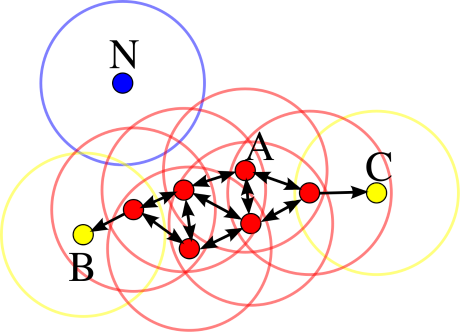

На рисунке отмечены типы точек:
   * красные точки &mdash; внутренние,
   * желтые точки &mdash; граничные,
   * синие точки &mdash; выбросы.  


Интерактивные примеры визуализации работы DBSCAN <a target="_top" href="https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/">здесь</a>.

---


#### Реализация DBSCAN из sklearn

> `DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)`  
>
> *Самые важные параметры*
> * `eps` &mdash; максимальное расстояние между двумя точками, которые можно считать соседями;
> * `min_samples` &mdash; минимальное количество соседних точек, определяющих эту группу точек как внутренние.  
>
> *Наиболее важные остальные параметры*
> * `algorithm` &mdash; метод для поиска ближайших соседей;
> * `n_jobs` &mdash; позволяет распараллелить вычисления на `n_jobs` задач. Может пригодится работы с очень большими данными.  
>
> *Методы*  
> * `fit(self, X[, y, sample_weight])` &mdash; обучиться на данных `X`;
> * `fit_predict(self, X[, y, sample_weight])` &mdash; обучиться на данных `X` и вернуть номера кластеров.
>
> *Наиболее важные атрибуты*
> * `core_sample_indices_` &mdash; индексы внутренних точек, определенных методом;
> * `labels_` &mdash; лейблы точек, соответствующие предсказанным кластерам.
>
> *Примечание.*
> Выбросы, детектированные методом, имеют лейбл `-1`.

---

Применим DBSCAN к нашим данным и визуализируем кластеризацию. На графике крупные точки являются внутренними, небольшие точки &mdash; граничные, черные &mdash; выбросы. Метод определил в данных 4 кластера и некоторое количество выбросов.

In [6]:
def visualize_dbscan_predicts(
    dbscan: sklearn.cluster.DBSCAN,
    legend: str = "full",
    scale_sizes: float = 1,
    title: Optional[str] = None,
) -> None:
    """
    Визуализирует результаты DBSCAN, выделяя внутренние, граничные точки и выбросы.

    Параметры:
        dbscan (sklearn.cluster.DBSCAN): Обученная модель DBSCAN.
        legend (str): Тип легенды для seaborn.scatterplot. По умолчанию "full".
        scale_sizes (float): Коэффициент масштабирования размеров точек. По умолчанию 1.
        title (Optional[str]): Заголовок графика. Если None, заголовок не отображается.
    """
    # Делаем маску внутренних точек
    core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True

    # Достаем предсказанные кластеры
    labels = dbscan.labels_

    # Визуализируем
    if title is not None:
        plt.title(title)

    label_names = {-1: "Выбросы"} | {
        label: f"Кластер {label}" for label in set(labels) if label != -1
    }
    palette = {
        name: sns.palettes.color_palette("Set2")[label % 8]
        for label, name in label_names.items()
        if label != -1
    } | {"Выбросы": (0, 0, 0)}

    sns.scatterplot(
        x=data[:, 0],
        y=data[:, 1],
        hue=map(lambda l: label_names[l], labels),
        size=[
            "Внутренние точки" if is_core else "Граничные точки" for is_core in core_samples_mask
        ],
        sizes={
            "Внутренние точки": 30 * scale_sizes,
            "Граничные точки": 10 * scale_sizes,
        },
        palette=palette,
        alpha=0.7,
        legend=legend,
    )

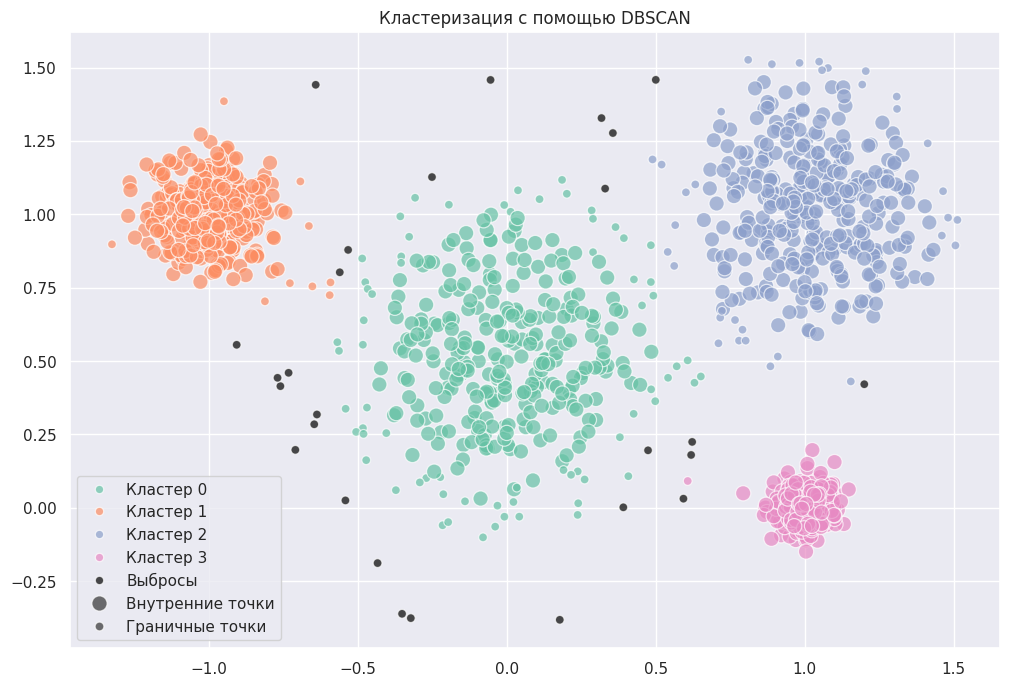

In [7]:
# Обучаем DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=25)
dbscan.fit(data)

# Визуализируем
plt.figure(figsize=(12, 8))
visualize_dbscan_predicts(
    dbscan, legend="full", scale_sizes=4, title="Кластеризация с помощью DBSCAN"
)
plt.show()

Посмотрим, как меняется результат кластеризации в зависимости от параметров $\varepsilon=$ `eps` и $m=$ `min_samples`.

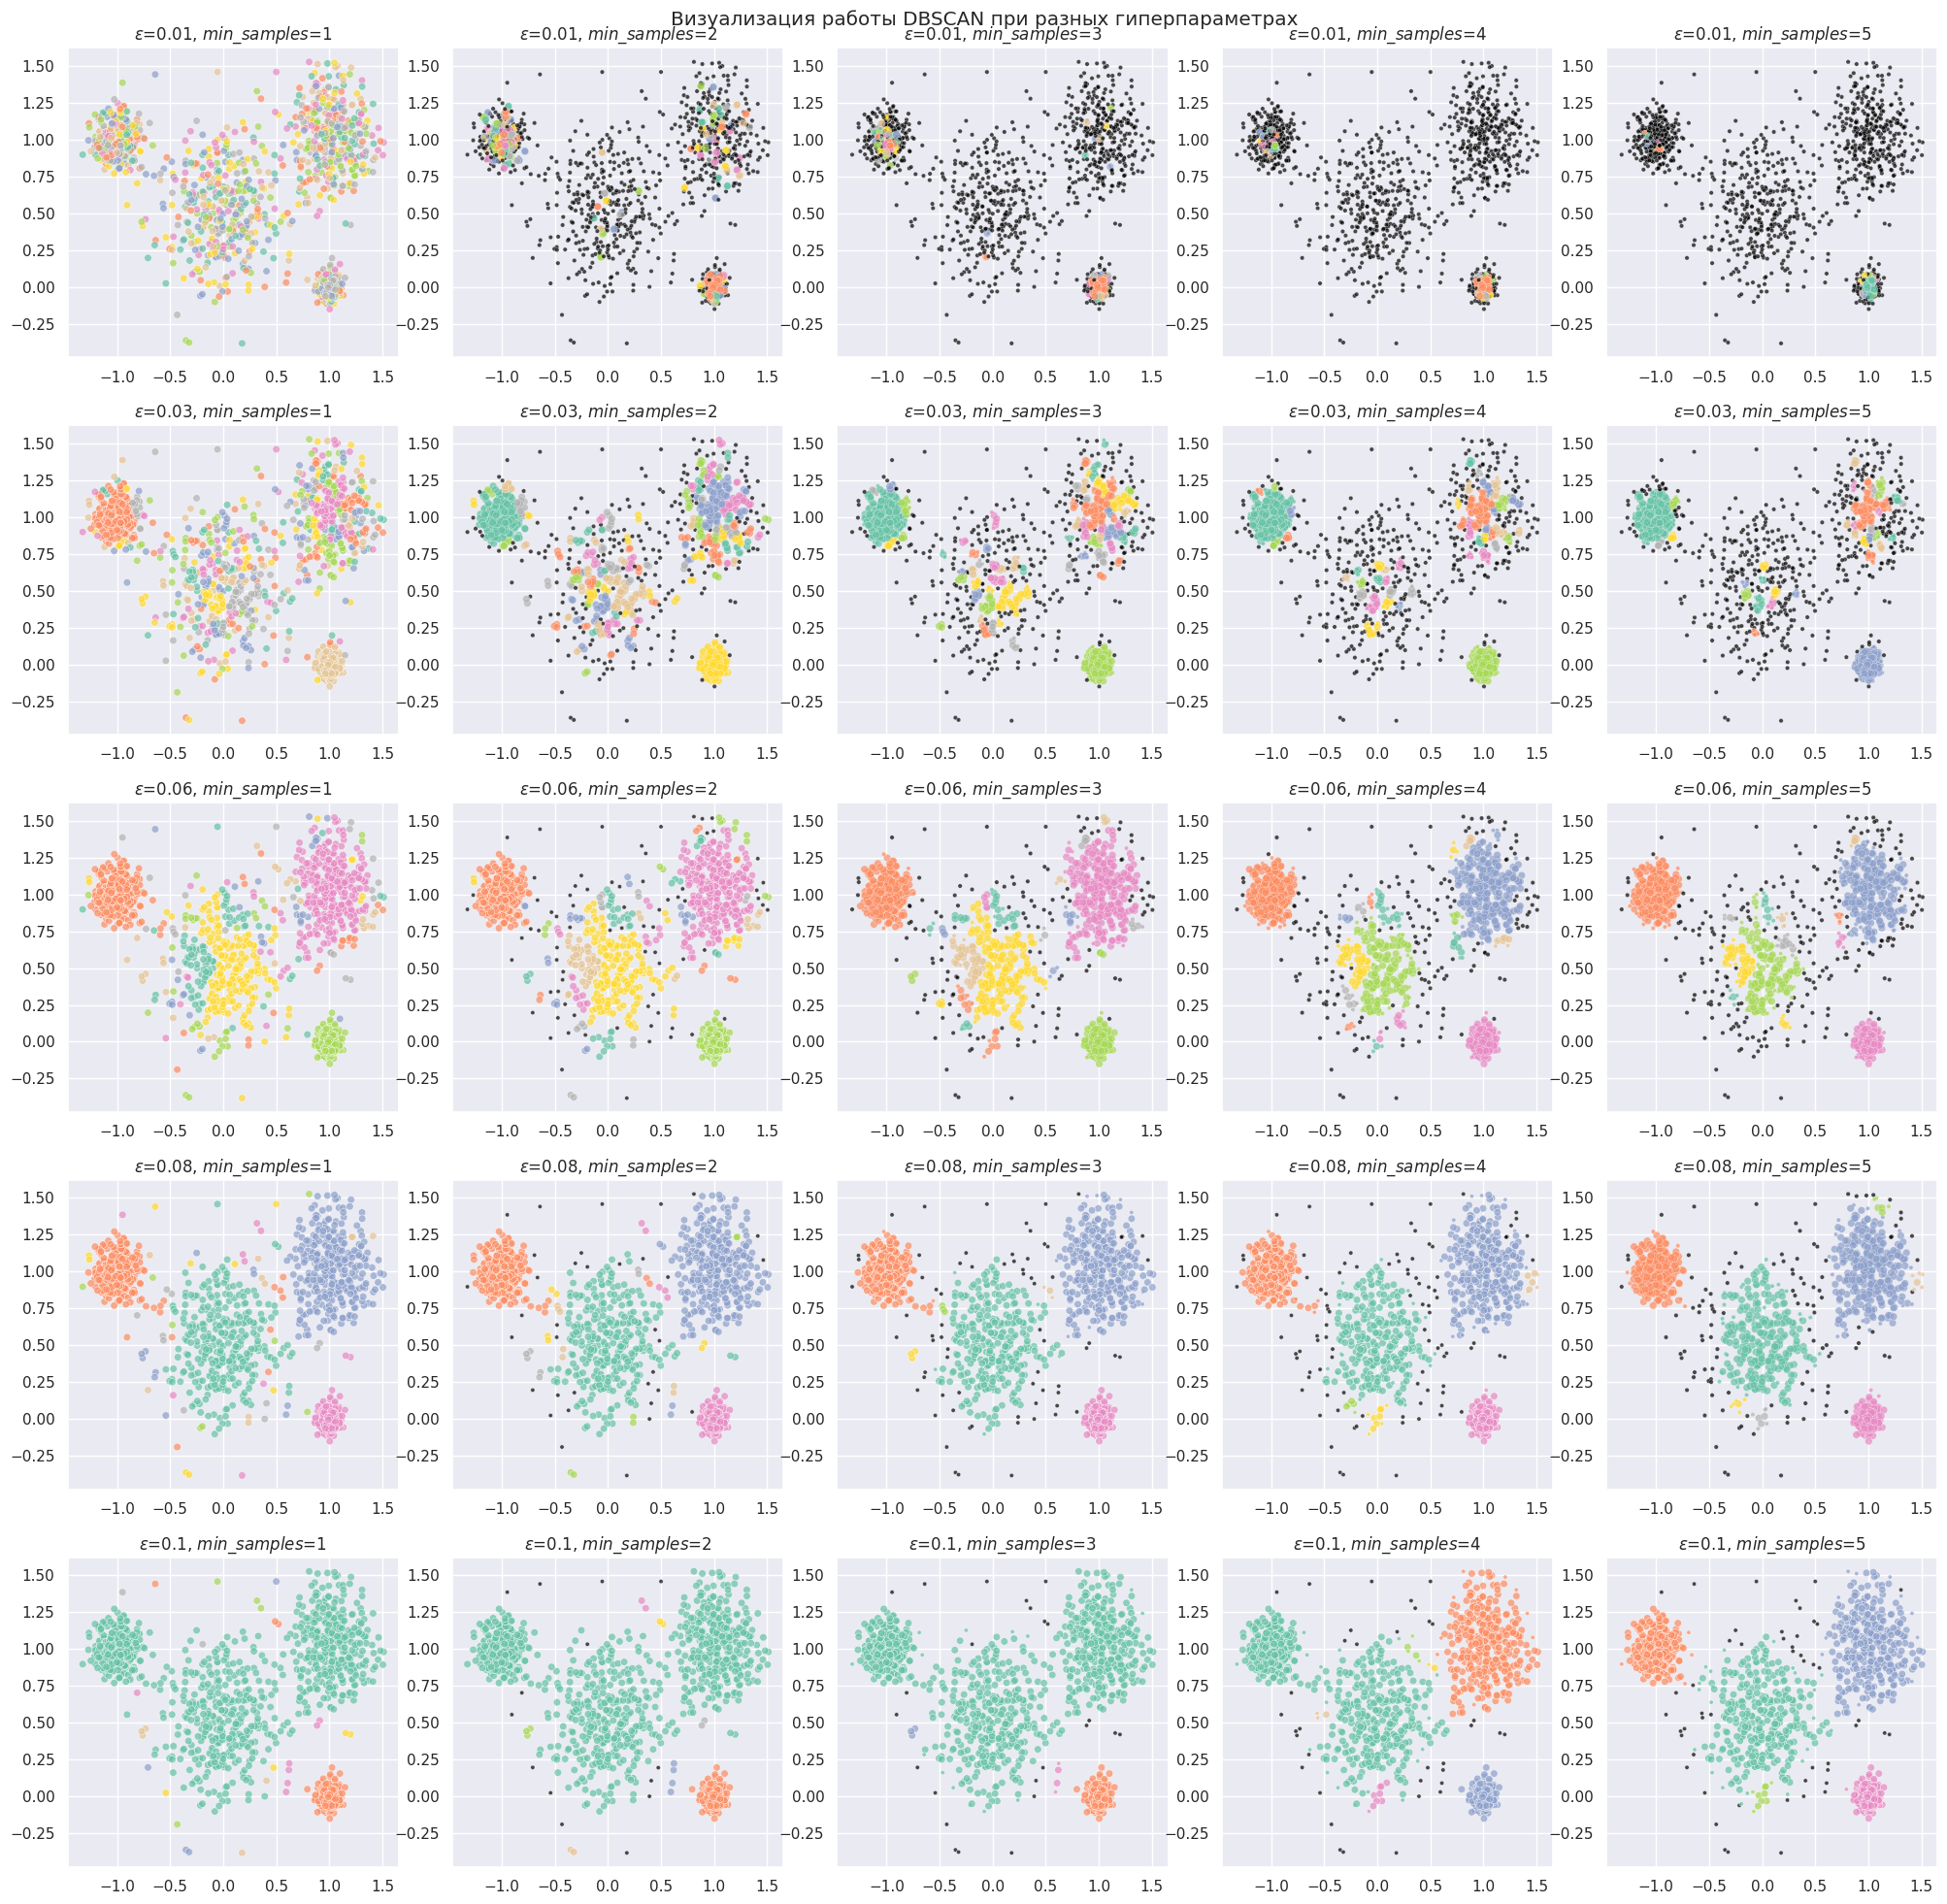

In [8]:
# Сетка параметров
eps_grid = np.linspace(0.01, 0.1, 5)
min_samples_grid = np.arange(1, 6)

fig = plt.figure(figsize=(20, 20))
fig.suptitle("Визуализация работы DBSCAN при разных гиперпараметрах")

for i, eps in enumerate(eps_grid):
    for j, min_samples in enumerate(min_samples_grid):
        # Предсказываем кластеры
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(data)

        # Визуализируем
        plt.subplot(5, 5, i * 5 + j + 1)
        plt.title(f"$\\varepsilon$={np.round(eps, 2)}, $min\\_samples$={min_samples}")
        visualize_dbscan_predicts(dbscan, legend=False, scale_sizes=1)

plt.tight_layout()
plt.show()

Видим, что при некоторых параметрах (например, `eps = 0.08` и `min_samples=5`) DBSCAN справился неплохо. Но и не идеально: нет ни одной комбинации при которой бы было ровно 4 кластера близкие к правильным, везде есть какие-то дополнительные микрокластеры.

### 4. Сравнение методов

Теперь сравним работу методов на двух других интересных синтетических датасетах и поймем в каком случае какой метод лучше использовать.

In [9]:
# Генерируем недостающие данные
n_samples = 1500

# Вложенные окружности
noisy_circles, _ = sklearn.datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=RANDOM_STATE
)

# Две луны
noisy_moons, _ = sklearn.datasets.make_moons(
    n_samples=n_samples, noise=0.05, random_state=RANDOM_STATE
)

# Смесь эллипсоидов
params = [
    ([0, 0], [[0.1, 0], [0, 2.0]]),
    ([5, -5], [[2.0, 1.8], [1.8, 2.0]]),
    ([8, 6], [[0.5, 0], [0, 0.5]]),
    ([3, 0], [[5, 0], [0, 5]]),
]

ellipses = (
    np.concatenate(
        [
            sps.multivariate_normal(mean=mean, cov=cov).rvs(
                n_samples // 4, random_state=RANDOM_STATE
            )
            for mean, cov in params
        ]
    )
    / 4
)

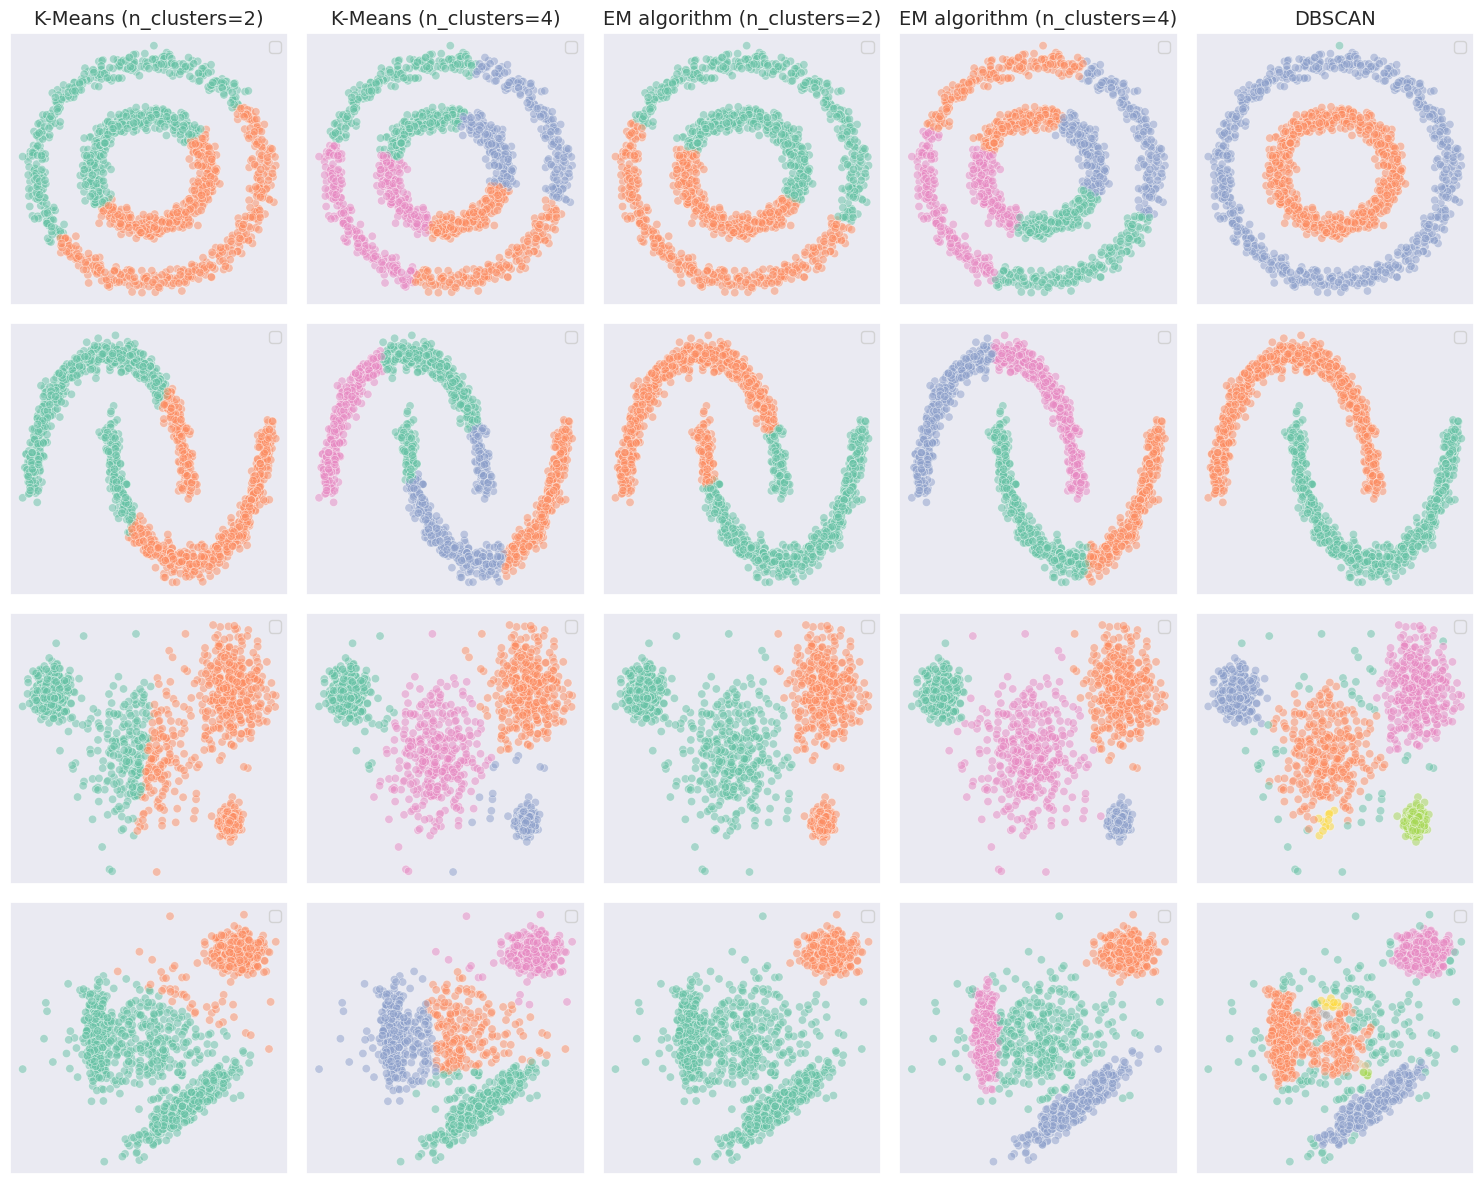

In [10]:
# Визуализируем
plt.figure(figsize=(15, 12))
plot_idx = 1
dataset_list = [noisy_circles, noisy_moons, data, ellipses]

# Создаем методы кластеризации
clustering_methods = (
    (
        "K-Means (n_clusters=2)",
        KMeans(n_clusters=2, random_state=RANDOM_STATE),
    ),
    (
        "K-Means (n_clusters=4)",
        KMeans(n_clusters=4, random_state=RANDOM_STATE),
    ),
    (
        "EM algorithm (n_clusters=2)",
        GaussianMixture(n_components=2, n_init=10, random_state=RANDOM_STATE),
    ),
    (
        "EM algorithm (n_clusters=4)",
        GaussianMixture(n_components=4, n_init=10, random_state=RANDOM_STATE),
    ),
    ("DBSCAN", dbscan),
)

for i_dataset, dataset in enumerate(dataset_list):
    for name, algorithm in clustering_methods:
        # Делаем предсказания
        predict_labels = algorithm.fit_predict(dataset)

        # Строим график точек и предсказанных меток
        plt.subplot(len(dataset_list), len(clustering_methods), plot_idx)
        if i_dataset == 0:
            plt.title(name, size=14)

        sns.scatterplot(
            x=dataset[:, 0],
            y=dataset[:, 1],
            hue=predict_labels,
            alpha=0.5,
            palette="Set2",
        )

        plt.legend(())
        plt.xticks(())
        plt.yticks(())
        plot_idx += 1

plt.tight_layout()
plt.show()

На графике видны существенные различия в результатах кластеризации, полученных с помощью разных методов. Исходя из контекста исследования, один метод может быть предпочтительнее другого.

Например, если взглянуть на первые два набора данных, можно предположить, что DBSCAN справляется гораздо лучше, чем методы k-means и EM-алгоритм, выделяя структуры данных более четко. Однако в случае, когда расстояние по оси X коррелирует с реальным физическим свойством и удаленность точек указывает на их непохожесть (как, скажем, площадь квартиры), k-means и EM-алгоритм на четырех классах, могут давать более подходящую кластеризацию.

Также отметим особенность последнего набора данных. Здесь видно, что EM-алгоритм может формировать невыпуклые кластеры, обычно это не очень хорошо и плохо интерпретируется. В отличие от него, k-means всегда создает выпуклые кластеры. К тому же, EM-алгоритм обладает гораздо большим количеством обучаемых параметров, так как он не только оценивает среднее для каждого кластера, но и подбирает дисперсии кластеров и вероятности принадлежности каждой точки к определенному кластеру, что добавляет дополнительную сложность и может привести к переобучению.


### 5. Кластеризация ответов в бот

В этом разделе проведем анализ ваших ответов на вопросы в бот. Для этого с помощью нейросети будем предсказывать эмбеддинги ответов и затем кластеризуем их k-means.

#### 5.1 Кластеризация ответов на вопрос "*Понравились ли вам нейросети?*"

Попробуем поискать какие-то закономерности в ответах на вопрос про нейросети за 2022 и 2024 года.


Загружаем ответы:

In [11]:
like_nn_answers = pd.read_csv("data/like_neuralnet_question.csv")
like_nn_answers

answer  \
0                                                  Одной минуты мало, чтобы выразить весь спектр эмоций)   
1                                                           Да, Лиза Дахова самый классный лектор по ад)   
2                                                               Да ❤️‍🔥 (возьмите на кафедру пожалуйста)   
3                                                                              Я бьюсь в экстазе!!!1!!1!   
4    Как искусственный интеллект, я не обладаю личными предпочтениями или эмоциями, поэтому мне не да...   
..                                                                                                   ...   
292                                                           ДА, ОЧЕНЬ ПОНРАВИЛОСЬ, Я ХОЧУ ОТ НИХ ДЕТЕЙ   
293                        Ну прикольно, но мне не нравится python, так, что такое, но таки норм норм 😎🫨   
294                                  Setting pad_token_id to eos_token_id: 50257 for open-end generation   
295                                                                     Главное, чтобы я понравилась им🙈   
296                                              Да, конечно, хочу на DS-поток, возьмите пж, я вас люблю   

                            question  year  
0    Вам понравились нейронные сети?  2022  
1    Вам понравились нейронные сети?  2022  
2    Вам понравились нейронные сети?  2022  
3    Вам понравились нейронные сети?  2022  
4    Вам понравились нейронные сети?  2024  
..                               ...   ...  
292  Вам понравились нейронные сети?  2024  
293  Вам понравились нейронные сети?  2024  
294  Вам понравились нейронные сети?  2024  
295  Вам понравились нейронные сети?  2024  
296  Вам понравились нейронные сети?  2024  

[297 rows x 3 columns]

Теперь загружаем из huggingface обученную модель с соответствующим токенизатором <b><a target="_top" href="https://huggingface.co/intfloat/multilingual-e5-small">intfloat/multilingual-e5-small</a></b> для получения эмбеддингов текста

In [12]:
def average_pool(last_hidden_states: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    """
    Выполняет усреднение скрытых состояний с учетом маски внимания.

    Усреднение проводится только по действительным токенам (где attention_mask = 1).
    Недействительные токены (где attention_mask = 0) обнуляются перед усреднением.

    Параметры:
        last_hidden_states: Тензор скрытых состояний формы [batch_size, seq_len, hidden_dim]
        attention_mask: Тензор маски внимания формы [batch_size, seq_len],
                       где 1 - действительный токен, 0 - padding токен

    Возвращает:
        Тензор усредненных скрытых состояний формы [batch_size, hidden_dim]
    """
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

In [13]:
model_name = "intfloat/multilingual-e5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Предсказываем эмбеддинги ответов

In [14]:
def make_embeddings(
    texts: Union[List[str], np.ndarray],
    model: PreTrainedModel,
    tokenizer: Optional[PreTrainedTokenizer] = None,
    batch_size: int = 16,
) -> torch.Tensor:
    """
    Вычисляет векторные представления (эмбеддинги) для массива текстов.

    Параметры:
        texts: Список или массив текстов для обработки
        model: Модель для генерации эмбеддингов (например, SentenceTransformer или HuggingFace модель)
        tokenizer: Токенизатор, соответствующий модели. Если None, используется встроенный токенизатор модели
        batch_size: Размер батча для обработки. Влияет на скорость и потребление памяти

    Возвращает:
        Тензор с эмбеддингами текстов формы [num_texts, embedding_dim]
    """
    text_embeddings = []

    for start_batch_idx in tqdm(range(0, len(texts), batch_size)):
        # Выбранная модель была обучена на входах, начинающихся с "query:" или "passage:".
        # Поэтому ко всем ответам надо добавить префикс "query:"
        input_texts = [
            "query: " + text for text in texts[start_batch_idx : start_batch_idx + batch_size]
        ]

        # Токенизируем тексты
        batch_dict = tokenizer(
            input_texts,
            max_length=512,
            padding=True,
            truncation=True,
            return_tensors="pt",
        )

        # Применяем модель
        with torch.no_grad():
            outputs = model(**batch_dict)

        # Агрегируем выходы в эмбеддинги и нормализуем их
        embeddings = average_pool(outputs.last_hidden_state, batch_dict["attention_mask"])
        embeddings = F.normalize(embeddings, p=2, dim=1)
        text_embeddings.append(embeddings)

    return torch.cat(text_embeddings).cpu().numpy()

In [15]:
like_nn_embeddings = make_embeddings(
    like_nn_answers["answer"], model=model, tokenizer=tokenizer, batch_size=16
)
like_nn_embeddings.shape

  0%|          | 0/19 [00:00<?, ?it/s]

(297, 384)

Для каждого ответа получили эмбеддинги размерности $384$.

Это очень много, можем столкнуться с проклятием размерности, поэтому **понизим размерность с помощью PCA, используя $10$ главных компонент.**

In [16]:
n_components_for_clustering = 10  # количество компонент для кластеризации

pca = PCA(n_components=n_components_for_clustering)
projection = pca.fit_transform(like_nn_embeddings)

Теперь применяем k-means на полученных эмбеддингах, будем разбивать их на 4 кластера

In [17]:
kmeans = KMeans(n_clusters=4, n_init=20, random_state=RANDOM_STATE)
like_nn_clusters = kmeans.fit_predict(projection)

**Для визуализации** полученных эмбеддингов спроецируем их **на двумерное пространство** с помощью PCA. Цветом покажем предсказанный кластер

In [18]:
n_components_for_visualization = 2  # количество компонент для визуализации

pca = PCA(n_components=n_components_for_visualization)
like_nn_projection = pca.fit_transform(like_nn_embeddings)

In [19]:
width = 1000
height = 800
size_max = 10

fig = px.scatter(
    x=like_nn_projection[:, 0],
    y=like_nn_projection[:, 1],
    hover_name=like_nn_clusters,
    hover_data={"answer": like_nn_answers["answer"]},
    color=like_nn_clusters.astype(str),
    width=width,
    height=height,
    title="PCA проекция эмбеддингов ответов на вопрос "
    '"Вам понравились нейронные сети?" на двумерное пространство',
    size=[1] * len(like_nn_answers),
    size_max=size_max,
)
fig.show()

Получилось довольно неплохое разделение:
- **Зеленый кластер**: очень короткие ответы "Да".
- **Фиолетовый кластер**: короткие нейтральные, отрицательные или трешовые ответы.
- **Красный кластер**: средней длины положительные ответы.
- **Синий кластер**: очень подробные преимущественно положительные ответы.

Для наглядности посмотрим на топ-5 типичных ответа для каждого кластера, где под типичностью имеется ввиду близость к центру масс.

In [20]:
cluster_names = [
    'Очень короткие ответы "Да"',
    "Короткие отрицательные, нейтральные или трешовые ответы",
    "Средней длины положительные ответы",
    "Очень подробные преимущественно положительные ответы",
]

for cluster in np.unique(like_nn_clusters):
    cluster_points = like_nn_projection[like_nn_clusters == cluster]
    cluster_answers = like_nn_answers.loc[like_nn_clusters == cluster, "answer"]

    # Находим центр кластера
    cluster_center = cluster_points.mean(axis=0)
    # Считаем расстояния до центра от каждой точки кластера
    distances = np.linalg.norm(cluster_center - cluster_points, axis=1)
    # Сортируем расстояния и берем индексы в порядке возрастания расстояний
    closest_idxs = np.argsort(distances)
    # Берем топ-5 уникальных ответов, соответствующих полученным индексам
    closest_answers = cluster_answers.iloc[closest_idxs].drop_duplicates()[:5]

    print(f"{cluster_names[cluster]}:")
    for i, ans in enumerate(closest_answers):
        print(f"    {i}. {ans}")
    print()

Очень короткие ответы "Да":
    0. да
    1. Да
    2. ДА!
    3. Да)
    4. ДА

Короткие отрицательные, нейтральные или трешовые ответы:
    0. Сети - да, математика на доске - нет
    1. Возможно
    2. Ну ок
    3. Перцептрон?
    4. +inf

Средней длины положительные ответы:
    0. Да, очень) Узнал много нового
    1. Да, очень, возьмите на DS-поток пожалуйста
    2. Да это ж круто!
    3. Да, спасибо за лекцию)
    4. Позвольте ответить песней: Да!
Спасибо за внимание

Очень подробные преимущественно положительные ответы:
    0. Относительно да. Мне нравится их применение, но совсем не нравится их математическая модель.
    1. Да, лекция крутая, стало примерно понятно как работают нейронки
    2. Да, обожаю биологию и всё, что с ней связано
Лектор ня
    3. Если честно, на этот курс я пришёл ради статов, чтобы лучше работать аб-тесты. Ну впринципе прикольненько)
    4. Очень сильно!!! Хочется узнать побольше



#### 5.2 Кластеризация ответов на тестовый вопрос

Теперь посмотрим на тестовый вопрос, который в разные годы звучал по-разному:

* 2022: "*Первый тестовый вопрос*"
* 2023: "*Первый тестовый вопрос. Напиши что-то текстом и отправь боту.*"
* 2024: "*Первый тестовый вопрос. Поприветствуй бота и расскажи ему что-нибудь о себе.*"
* 2025: "*Первый тестовый вопрос. Поприветствуй бота и расскажи ему что-нибудь о себе.*"

In [21]:
test_answers = pd.read_csv("data/test_question_2025.csv")
test_answers

answer  \
0                                                                     абоба   
1                                                                🎩\n🐸\n👕\n👖   
2                                 Спасибо за курс) Ожидаю что-то интересное   
3                                                             Крекеры — топ   
4                                                  Ответ на тестовый вопрос   
..                                                                      ...   
809                             Добрый вечер! Я недавно закрыла матан!!!!!!   
810  Приветствую. Сегодня прекрасный день, чтобы начать ботать)))\nХочу отл   
811        Привет)\nНемного о себе.\nГений. Миллиардер. Плейбой. Филантроп.   
812               Привет, я студент курса анализа данных и хочу на ДС поток   
813   Медвед\nИдёт медведь по лесу\nВидит машина горит - сел в нее и сгорел   

                                                                        question  \
0                                                         Первый тестовый вопрос   
1                                                         Первый тестовый вопрос   
2                                                         Первый тестовый вопрос   
3                                                         Первый тестовый вопрос   
4                                                         Первый тестовый вопрос   
..                                                                           ...   
809  Первый тестовый вопрос. Поприветствуй бота и расскажи ему что-нибудь о себе   
810  Первый тестовый вопрос. Поприветствуй бота и расскажи ему что-нибудь о себе   
811  Первый тестовый вопрос. Поприветствуй бота и расскажи ему что-нибудь о себе   
812  Первый тестовый вопрос. Поприветствуй бота и расскажи ему что-нибудь о себе   
813  Первый тестовый вопрос. Поприветствуй бота и расскажи ему что-нибудь о себе   

     year  
0    2022  
1    2022  
2    2022  
3    2022  
4    2022  
..    ...  
809  2024  
810  2024  
811  2024  
812  2024  
813  2024  

[814 rows x 3 columns]

Как и в прошлый раз считаем эмбеддинги, делаем кластеризацию и проецируем на двумерное пространство

In [22]:
# Считаем эмбеддинги
test_embeddings = make_embeddings(
    test_answers["answer"], model=model, tokenizer=tokenizer, batch_size=16
)

# Делаем проекцию в пространство меньшей размерности, чтобы избежать проклятие размерности
pca = PCA(n_components=n_components_for_clustering)
projection = pca.fit_transform(test_embeddings)

# Делаем кластеризацию
kmeans = KMeans(n_clusters=5, n_init=20, random_state=RANDOM_STATE)
test_clusters = kmeans.fit_predict(projection)

# Делаем проекцию на плоскость для визуализации
pca = PCA(n_components=n_components_for_visualization)
test_projection = pca.fit_transform(test_embeddings)

  0%|          | 0/51 [00:00<?, ?it/s]

In [23]:
# Интерактивная визуализация
fig = px.scatter(
    x=test_projection[:, 0],
    y=test_projection[:, 1],
    hover_name=test_clusters,
    hover_data={"answer": test_answers["answer"]},
    color=test_clusters.astype(str),
    width=width,
    height=height,
    title="PCA проекция эмбеддингов ответов на тестовый вопрос на двумерное пространство",
    size=[1] * len(test_answers),
    size_max=size_max,
)
fig.show()

Итак, видим тоже довольно логичные кластеры:
- **Оранжевый кластер**: короткий приветственный ответ.
- **Зеленый кластер**: относительно длинные ответы с рассказом про себя.
- **Фиолетовый кластер**: короткие ответы, содержащие слово "ответ", "текст" или "тест".
- **Синий кластер**: трешовые ответы на кириллице.
- **Красный кластер**: трешовые ответы на латинице, эмодзи или цифры.

Как и ранее посмотрим на топ-5 типичных ответов каждого кластера:

In [24]:
cluster_names = [
    'Короткие ответы, содержащие слово "ответ", "текст" или "тест"',
    "Трешовые ответы на латинице, эмодзи или цифры",
    "Короткий приветственный ответ",
    "Относительно длинные ответы с рассказом про себя",
    "Трешовые ответы на кириллице",
]

for cluster in np.unique(test_clusters):
    cluster_points = test_projection[test_clusters == cluster]
    cluster_answers = test_answers.loc[test_clusters == cluster, "answer"]

    # Находим центр кластера
    cluster_center = cluster_points.mean(axis=0)
    # Считаем расстояния до центра от каждой точки кластера
    distances = np.linalg.norm(cluster_center - cluster_points, axis=1)
    # Сортируем расстояния и берем индексы в порядке возрастания расстояний
    closest_idxs = np.argsort(distances)
    # Берем топ-5 уникальных ответов, соответствующих полученным индексам
    closest_answers = cluster_answers.iloc[closest_idxs].drop_duplicates()[:5]

    print(f"{cluster_names[cluster]}:")
    for i, ans in enumerate(closest_answers):
        print(f"    {i}. {ans}")
    print()

Короткие ответы, содержащие слово "ответ", "текст" или "тест":
    0. Другой ответ
    1. Ответ.
    2. изменение ответа
    3. какой ответ
    4. снова ответ

Трешовые ответы на латинице, эмодзи или цифры:
    0. Salamaleikum
    1. Amogus
    2. ahahhaa
    3. )
    4. Ggg

Короткий приветственный ответ:
    0. Привет)
    1. Привет🥺
    2. Привет ((
    3. Привет2
    4. Привет!

Относительно длинные ответы с рассказом про себя:
    0. Привет! Я Мавджуда из 253й группы
    1. Привет! Учусь на ПМИ.Классика, играю в хоккей 🏒
    2. Очень правильный студент, добрый позитивный, понимаю в сыре
    3. Добрый вечер. Майнкрафт это моя жизнь
    4. Привет! Я с ПМИ.информатика! Родом из тундры

Трешовые ответы на кириллице:
    0. Яхаааапаа
    1. Максим
    2. Текст любой
    3. Лольк
    4. Данные



#### 5.3 Кластеризация ответов на вопрос про кластеризацию

Посмотрим ответы на вопрос, заданный студентам в прошлом году во время аналогичного занятия:

> *Имеется несколько тысяч супермаркетов. Цель: кластеризовать магазины по похожести, внутри кластеров выявить успешные магазины, определить для остальных магазинов в кластере точки роста.*
>
> *Вопрос: как кластеризовать, как измерить качество?*
>
> *Напиши результат обсуждения в команде (для каждого студента из команды)*

In [25]:
def add_new_lines(text: str, words_per_line: int = 12) -> str:
    """
    Форматирует текст, добавляя переносы строк через указанное количество слов.

    Исходные переносы строк заменяются на HTML-тег <br>.
    Полезно для подготовки текста к отображению в HTML.

    Параметры:
        text: Исходный текст для форматирования
        words_per_line: Количество слов в одной строке перед переносом (по умолчанию 12)

    Возвращает:
        str: Текст с HTML-переносами строк, где:
             - Каждые N слов (words_per_line) разделяются тегом <br>
             - Все исходные переносы заменяются на <br>
    """
    words = text.split(" ")
    new_text = ""

    for start_idx in range(0, len(words), 12):
        new_text += " ".join(words[start_idx : start_idx + 12]) + "<br>"

    return new_text.replace("\n", "<br>")

In [26]:
new_answers = pd.read_csv("data/new_question.csv")

# Добавляем переносы строк каждые 12 слов для удобной визуализации
# (при построении эмбеддингов используем нормальные ответы)
new_answers["answer_new_lines"] = new_answers["answer"].apply(add_new_lines)
new_answers

answer  \
0    Для кластеризации магазинов можно воспользоваться алгоритмами машинного обучения, такими как k-m...   
1    1) Кластеров должно быть не очень много и не очень мало\n2) Кластеры должны отражать близость ма...   
2    Кодируем признаки (кроме первых двух, выручка и потери являются мерой успеха), стандартизируем и...   
3    1.Определим критерии для кластеризации. Это могут быть продажи, площадь магазина, количество сот...   
4    Сначала выберем значимые признаки: продажи и выпуска, площадь зала, торговые центры рядом, плотн...   
..                                                                                                   ...   
132  Метод k-средних (k-means) - это алгоритм кластерного анализа, который используется для разделени...   
133  Делаем кластеризацию по всем признакам, признаки с наибольшем весом - трафик, площадь, выручка з...   
134  Кластеризовать супермаркеты можно по окружению, их характеристикам. вроде размера и количества с...   
135  Кластеризовать используя Kmeans, каждый раз соединять наиболее близкие магазины в 1 класер, пока...   
136  кластеризовать следует по отдельным товарам и категориям, так как они задают схожесть магазинов\...   

                                                                                                question  \
0    Имеется несколько тысяч супермаркетов. Цель: кластеризовать магазины по похожести, внутри класте...   
1    Имеется несколько тысяч супермаркетов. Цель: кластеризовать магазины по похожести, внутри класте...   
2    Имеется несколько тысяч супермаркетов. Цель: кластеризовать магазины по похожести, внутри класте...   
3    Имеется несколько тысяч супермаркетов. Цель: кластеризовать магазины по похожести, внутри класте...   
4    Имеется несколько тысяч супермаркетов. Цель: кластеризовать магазины по похожести, внутри класте...   
..                                                                                                   ...   
132  Имеется несколько тысяч супермаркетов. Цель: кластеризовать магазины по похожести, внутри класте...   
133  Имеется несколько тысяч супермаркетов. Цель: кластеризовать магазины по похожести, внутри класте...   
134  Имеется несколько тысяч супермаркетов. Цель: кластеризовать магазины по похожести, внутри класте...   
135  Имеется несколько тысяч супермаркетов. Цель: кластеризовать магазины по похожести, внутри класте...   
136  Имеется несколько тысяч супермаркетов. Цель: кластеризовать магазины по похожести, внутри класте...   

                                                                                        answer_new_lines  
0    Для кластеризации магазинов можно воспользоваться алгоритмами машинного обучения, такими как k-m...  
1    1) Кластеров должно быть не очень много и не очень мало<br>2) Кластеры<br>должны отражать близос...  
2    Кодируем признаки (кроме первых двух, выручка и потери являются мерой успеха), стандартизируем<b...  
3    1.Определим критерии для кластеризации. Это могут быть продажи, площадь магазина, количество сот...  
4    Сначала выберем значимые признаки: продажи и выпуска, площадь зала, торговые центры рядом,<br>пл...  
..                                                                                                   ...  
132  Метод k-средних (k-means) - это алгоритм кластерного анализа, который используется для разделени...  
133  Делаем кластеризацию по всем признакам, признаки с наибольшем весом - трафик, площадь,<br>выручк...  
134  Кластеризовать супермаркеты можно по окружению, их характеристикам. вроде размера и количества с...  
135  Кластеризовать используя Kmeans, каждый раз соединять наиболее близкие магазины в 1 класер,<br>п...  
136  кластеризовать следует по отдельным товарам и категориям, так как они задают схожесть<br>магазин...  

[137 rows x 3 columns]

Как и ранее предсказываем эмбеддинги, делаем проекцию и кластеризуем

In [27]:
# Считаем эмбеддинги
new_embeddings = make_embeddings(
    new_answers["answer"], model=model, tokenizer=tokenizer, batch_size=16
)

# Делаем проекцию в пространство меньшей размерности, чтобы избежать проклятие размерности
pca = PCA(n_components=n_components_for_clustering)
projection = pca.fit_transform(new_embeddings)

# Делаем кластеризацию
kmeans = KMeans(n_clusters=5, n_init=10, random_state=RANDOM_STATE)
new_clusters = kmeans.fit_predict(projection)

# Делаем проекцию на плоскость для визуализации
pca = PCA(n_components=n_components_for_visualization)
new_projection = pca.fit_transform(new_embeddings)

  0%|          | 0/9 [00:00<?, ?it/s]

Визуализируем:

In [28]:
# Интерактивная визуализация
fig = px.scatter(
    x=new_projection[:, 0],
    y=new_projection[:, 1],
    hover_name=new_clusters,
    hover_data={"answer": new_answers["answer_new_lines"]},
    color=new_clusters.astype(str),
    width=width,
    height=height,
    title="PCA проекция эмбеддингов ответов на новые вопросы на двумерное пространство",
    size=[1] * len(new_answers),
    size_max=size_max,
)
fig.show()

- **Синий кластер**: расписано более подробно как и с помощью каких методов кластеризовать (часто встречаются такие слова как k-means, dbscan, hierarchical clustering, PCA).
- **Фиолетовый кластер**: в ответах обычно содержится список физических признаков, по которым можно делать кластеризацию.
- **Красный кластер**: ответы в виде списка пунктов.
- **Зеленый кластер**: похож на синий кластер, но менее подробное описание, без приведения примеров конкретных методов.
- **Оранжевый кластер**: мяу, restart и соня🙃

In [29]:
cluster_names = [
    "Расписано чуть более подробно как и с помощью каких методов кластеризовать (часто встречаются такие слова как k-means, dbscan, hierarchical clustering, PCA)",
    "В ответах обычно содержится список физических признаков, по которым можно делать кластеризацию",
    "Ответы в виде списка пунктов",
    "Похож на синий кластер, но менее подробное описание, без приведения примеров конкретных методов",
    "Мяу, restart и соня🙃",
]

for cluster in np.unique(new_clusters):
    cluster_points = new_projection[new_clusters == cluster]
    cluster_answers = new_answers.loc[new_clusters == cluster, "answer"]

    # Находим центр кластера
    cluster_center = cluster_points.mean(axis=0)
    # Считаем расстояния до центра от каждой точки кластера
    distances = np.linalg.norm(cluster_center - cluster_points, axis=1)
    # Сортируем расстояния и берем индексы в порядке возрастания расстояний
    closest_idxs = np.argsort(distances)
    # Берем топ-5 уникальных ответов, соответствующих полученным индексам
    closest_answers = cluster_answers.iloc[closest_idxs].drop_duplicates()[:5]

    print(f"{cluster_names[cluster]}:")
    for i, ans in enumerate(closest_answers):
        print(f"    {i}. {ans}\n" + "-" * 10)
    print("\n\n" + "-" * 100 + "\n")

Расписано чуть более подробно как и с помощью каких методов кластеризовать (часто встречаются такие слова как k-means, dbscan, hierarchical clustering, PCA):
    0. Для кластеризации магазинов можно использовать методы машинного обучения, такие как k-means или hierarchical clustering.

Предлагаю использовать алгоритм k-means для кластеризации магазинов, так как он хорошо работает с большими объемами данных.

Общее согласие в команде было достигнуто по использованию k-means для кластеризации, индекса Дэвиса-Болдина для оценки качества, а также на необходимость учета бизнес-контекста при определении успешности и точек роста магазинов.
----------
    1. Для решения задачи кластеризации супермаркетов, мы можем использовать метод k-средних или иерархическую кластеризацию. Выбор метода зависит от количества переменных и их типов. В качестве входных данных могут использоваться различные показатели эффективности работы магазина, такие как выручка, количество посетителей, средний чек и другие.


#### 5.4 Кластеризация ответов на вопрос про беспилотные автомобили

И наконец посмотрим ваши ответы на вопрос про беспилотные автомобили:

> *Хотели бы вы увидеть беспилотные автомобили/такси/трамваи в Москве? Стали бы вы ими пользоваться. и доверяете ли вы им?*


In [30]:
sdc_answers = pd.read_csv("data/self_driving_cars.csv")

# Добавляем переносы строк каждые 12 слов для удобной визуализации
# (при построении эмбеддингов используем нормальные ответы)
sdc_answers["answer_new_lines"] = sdc_answers["answer"].apply(add_new_lines)
sdc_answers

answer  \
0                                                   Зависит от того, кто будет являться их разработчиком   
1    Да, стала бы. Доверяю\nПару раз видела на улицах Москвы беспилотные автомобили в Хамовниках и бе...   
2                                                                                                     да   
3    Нет не сильно. Должно пройти время чтоб они обучились чтоли. И внедренние таких технологий с нул...   
4                                                                                                    Нет   
..                                                                                                   ...   
177                                                                                                   Да   
178                                                                                             нет, нет   
179                                                                                                  Да!   
180                                                                                Если бесплатно, то да   
181                                                                                                   да   

                                                                                                question  \
0    Вопрос не оценивается\n\nХотели бы вы увидеть беспилотные автомобили/такси/трамваи в Москве? Ста...   
1    Вопрос не оценивается\n\nХотели бы вы увидеть беспилотные автомобили/такси/трамваи в Москве? Ста...   
2    Вопрос не оценивается\n\nХотели бы вы увидеть беспилотные автомобили/такси/трамваи в Москве? Ста...   
3    Вопрос не оценивается\n\nХотели бы вы увидеть беспилотные автомобили/такси/трамваи в Москве? Ста...   
4    Вопрос не оценивается\n\nХотели бы вы увидеть беспилотные автомобили/такси/трамваи в Москве? Ста...   
..                                                                                                   ...   
177  Вопрос не оценивается\n\nХотели бы вы увидеть беспилотные автомобили/такси/трамваи в Москве? Ста...   
178  Вопрос не оценивается\n\nХотели бы вы увидеть беспилотные автомобили/такси/трамваи в Москве? Ста...   
179  Вопрос не оценивается\n\nХотели бы вы увидеть беспилотные автомобили/такси/трамваи в Москве? Ста...   
180  Вопрос не оценивается\n\nХотели бы вы увидеть беспилотные автомобили/такси/трамваи в Москве? Ста...   
181  Вопрос не оценивается\n\nХотели бы вы увидеть беспилотные автомобили/такси/трамваи в Москве? Ста...   

                                                                                        answer_new_lines  
0                                               Зависит от того, кто будет являться их разработчиком<br>  
1    Да, стала бы. Доверяю<br>Пару раз видела на улицах Москвы беспилотные автомобили в<br>Хамовниках...  
2                                                                                                 да<br>  
3    Нет не сильно. Должно пройти время чтоб они обучились чтоли. И внедренние<br>таких технологий с ...  
4                                                                                                Нет<br>  
..                                                                                                   ...  
177                                                                                               Да<br>  
178                                                                                         нет, нет<br>  
179                                                                                              Да!<br>  
180                                                                            Если бесплатно, то да<br>  
181                                                                                               да<br>  

[182 rows x 3 columns]

Кластеризуем аналогично предыдущим вопросам

In [31]:
# Считаем эмбеддинги
sdc_embeddings = make_embeddings(
    sdc_answers["answer"], model=model, tokenizer=tokenizer, batch_size=16
)

# Делаем проекцию в пространство меньшей размерности, чтобы избежать проклятие размерности
n_components_for_clustering = 20
pca = PCA(n_components=n_components_for_clustering)
projection = pca.fit_transform(sdc_embeddings)

# Делаем кластеризацию
kmeans = KMeans(n_clusters=4, n_init=10, random_state=RANDOM_STATE)
sdc_clusters = kmeans.fit_predict(projection)

# Делаем проекцию
pca = PCA(n_components=n_components_for_visualization)
sdc_projection = pca.fit_transform(sdc_embeddings)

  0%|          | 0/12 [00:00<?, ?it/s]

Визуализируем:

In [32]:
# Интерактивная визуализация
fig = px.scatter(
    x=sdc_projection[:, 0],
    y=sdc_projection[:, 1],
    hover_name=sdc_clusters,
    hover_data={"answer": sdc_answers["answer_new_lines"]},
    color=sdc_clusters.astype(str),
    width=width,
    height=height,
    title="PCA проекция эмбеддингов ответов на новые вопросы на двумерное пространство",
    size=[1] * len(sdc_answers),
    size_max=size_max,
)
fig.show()

- **Красный кластер**: короткие ответы из одного слова "да".
- **Фиолетовый** и **бирюзовый кластера**: чуть более длинные положительные ответы, но без пояснений.
- **Зеленый кластер**: отрицательный ответ без пояснений.
- **Синий кластер**: различные ответы с подробным объяснением, почему стал бы или наоборот не стал бы пользоваться.
- **Оранжевый кластер**: в основном трешовые ответы

In [33]:
cluster_names = [
    "Отрицательный ответ без пояснений",
    "Различные ответы с подробным объяснением, почему стал бы или наоборот не стал бы пользоваться",
    'Короткие ответы из одного слова "да"',
    "Чуть более длинные положительные ответы, но без пояснений",
    "Чуть более длинные положительные ответы, но без пояснений",
    "В основном трешовые ответы",
]

for cluster in np.unique(sdc_clusters):
    cluster_points = sdc_projection[sdc_clusters == cluster]
    cluster_answers = sdc_answers.loc[sdc_clusters == cluster, "answer"]

    # Находим центр кластера
    cluster_center = cluster_points.mean(axis=0)
    # Считаем расстояния до центра от каждой точки кластера
    distances = np.linalg.norm(cluster_center - cluster_points, axis=1)
    # Сортируем расстояния и берем индексы в порядке возрастания расстояний
    closest_idxs = np.argsort(distances)
    # Берем топ-5 уникальных ответов, соответствующих полученным индексам
    closest_answers = cluster_answers.iloc[closest_idxs].drop_duplicates()[:5]

    print(f"{cluster_names[cluster]}:")
    for i, ans in enumerate(closest_answers):
        print(f"    {i}. {ans}\n")
    print("\n\n" + "-" * 100 + "\n")

Отрицательный ответ без пояснений:
    0. Идея интересная, но не особо практичная, в первую очередь из соображений безопасности.

    1. Звучит неплохо. Трамваям спокойнее, автомобилям скорее спустя время

    2. Хочу! Это развитие ИИ и за этим как минимум интересно следить. Но пользоваться на первых стадиях не стал бы.

    3. Хочу, чтобы такси было дешевле

    4. Да, хотел бы, если бы это сделало цену проезда на общественном траспорте поменьше



----------------------------------------------------------------------------------------------------

Различные ответы с подробным объяснением, почему стал бы или наоборот не стал бы пользоваться:
    0. да

    1. Да

    2. Да?

    3. Да!

    4. да, да



----------------------------------------------------------------------------------------------------

Короткие ответы из одного слова "да":
    0. Нет; нет; не доверяю

    1. хочу

    2. Кринж

    3. норм, почему бы и нет

    4. Скорее да, чем нет



-------------------------------